Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [204]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy
import plotly.express as px
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd,MultiComparison
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
from tqdm.auto import tqdm
from scipy.stats import norm

In [205]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep = ';')

In [206]:
# Посмотрим кол-во пользователей в группах и доход
df.groupby('testgroup', as_index = False).agg({'revenue' : 'sum', 'user_id' : 'count'})

,testgroup,revenue,user_id
0,a,5136189,202103
1,b,5421603,202667


In [207]:
# Конверсия

In [208]:
cr_a = round(df.query('testgroup == "a" & revenue > 0').user_id.nunique() / df.query('testgroup == "a"').user_id.nunique() * 100, 5)

In [209]:
cr_b = round(df.query('testgroup == "b" & revenue > 0').user_id.nunique() / df.query('testgroup == "b"').user_id.nunique() * 100, 5)

In [210]:
# Проверим разницу CR
round((cr_b/cr_a-1)* 100, 2)

-6.64

Конверсия в тестовой группе ниже на 6.64%

In [211]:
# Рассчитаем ARPU для каждой группы

In [212]:
arpu_a = round((df.query('testgroup == "a"').revenue.sum() / df.query('testgroup == "a" & revenue > 0').user_id.nunique())* cr_a, 2)

In [213]:
arpu_b = round((df.query('testgroup == "b"').revenue.sum() / df.query('testgroup == "b" & revenue > 0').user_id.nunique())* cr_b, 2)

In [214]:
# Проверим разницу между ARPU

In [215]:
round((arpu_b/arpu_a-1) * 100, 2)

5.26

В тестовой группе ARPU выше на 5.26%

In [216]:
stats.shapiro(df.query('testgroup == "a"').revenue.sample(1000, random_state=17))

(0.06614720821380615, 0.0)

In [217]:
stats.shapiro(df.query('testgroup == "b"').revenue.sample(1000, random_state=17))

(0.06715953350067139, 0.0)

In [218]:
def bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values 
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        boot_data.append(statistic([samples_1 - samples_2])) # применяем статистику

        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Конверсия

In [219]:
df['pay'] = np.where(df.revenue>0, 1, 0)
# Переводим в булевое значение и создаем новый столбец

In [220]:
cr_df = df.groupby(['user_id', 'testgroup'], as_index=False).agg({'revenue':'count','pay':'sum'})

In [221]:
cr_df = cr_df.rename(columns = {'revenue':'visits', 'pay':'number_of_purchase'})

In [222]:
cr_df['CR'] = cr_df['number_of_purchase']/cr_df['visits']*100

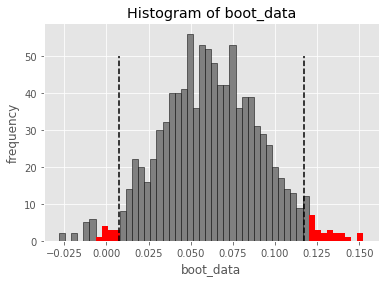

In [223]:
cr_control = cr_df.query('testgroup == "a"').CR
cr_test = cr_df.query('testgroup == "b"').CR
cr = bootstrap (cr_control, cr_test)

In [224]:
cr['quants']

,0
0.025,0.007340
0.975,0.117446


In [225]:
cr['p_value']

0.034103357985528826

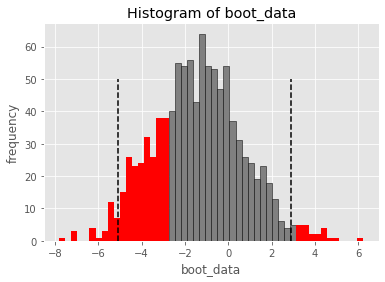

In [226]:
control_revenue = df.query('testgroup == "a"').revenue
test_revenue = df.query('testgroup == "b"').revenue
mean = bootstrap(control_revenue, test_revenue)

In [227]:
mean['quants']

,0
0.025,-5.103542
0.975,2.879222


In [228]:
mean['p_value']

0.5080721731462401

Вывод:
Исходя из того, что разность конверсий статистически значима, то можно считать тестовую группу предпочтительным вариантом.